# Transformer
ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import math
import re
import collections
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from model.playDL import *

## Transformer Structure

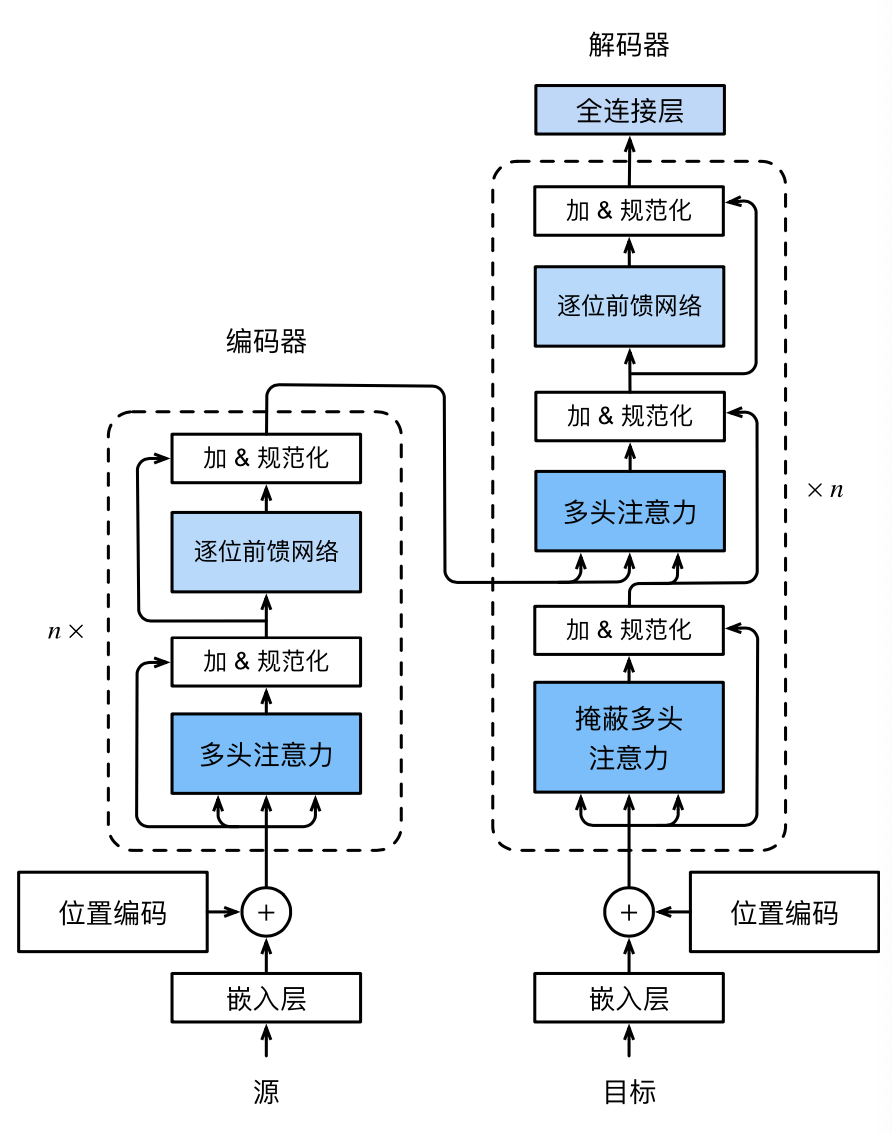

## Feed Forward
基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机(MLP)，这就是称前馈网络是基于位置的(positionwise)的原因。在下面的实现中，输入X的形状(批量大小，时间步数或序列⻓度，隐单元数或特征维度)将被一个两层的感知机转换成形状为(批量大小，时间步数，ffn_num_outputs) 的输出张量。

In [2]:
class PositionWiseFFN(nn.Module):
  """基于位置的前馈网络"""
  def __init__(self, ffn_num_input, ffn_num_hiddens, 
               ffn_num_outputs, **kwargs):
    super().__init__(**kwargs)
    self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
    self.activate = nn.ReLU()
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
  
  def forward(self, X):
    return self.dense2(self.activate(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.4333, -0.4324,  0.2642,  0.1975, -0.4999, -0.0079, -0.2909, -0.3731],
        [ 0.4333, -0.4324,  0.2642,  0.1975, -0.4999, -0.0079, -0.2909, -0.3731],
        [ 0.4333, -0.4324,  0.2642,  0.1975, -0.4999, -0.0079, -0.2909, -0.3731]],
       grad_fn=<SelectBackward0>)

## Add Residual and Norm

在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。(对于序列来说，长度常常是不固定的，所以batchnorm是比较困难的)

In [4]:
class AddNorm(nn.Module):
  """残差连接后进行层规范化"""
  def __init__(self, normalized_shape, dropout, **kwargs):
    super().__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(normalized_shape)

  def forward(self, X, Y):
    return self.ln(self.dropout(Y) + X)

In [5]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## Encoder

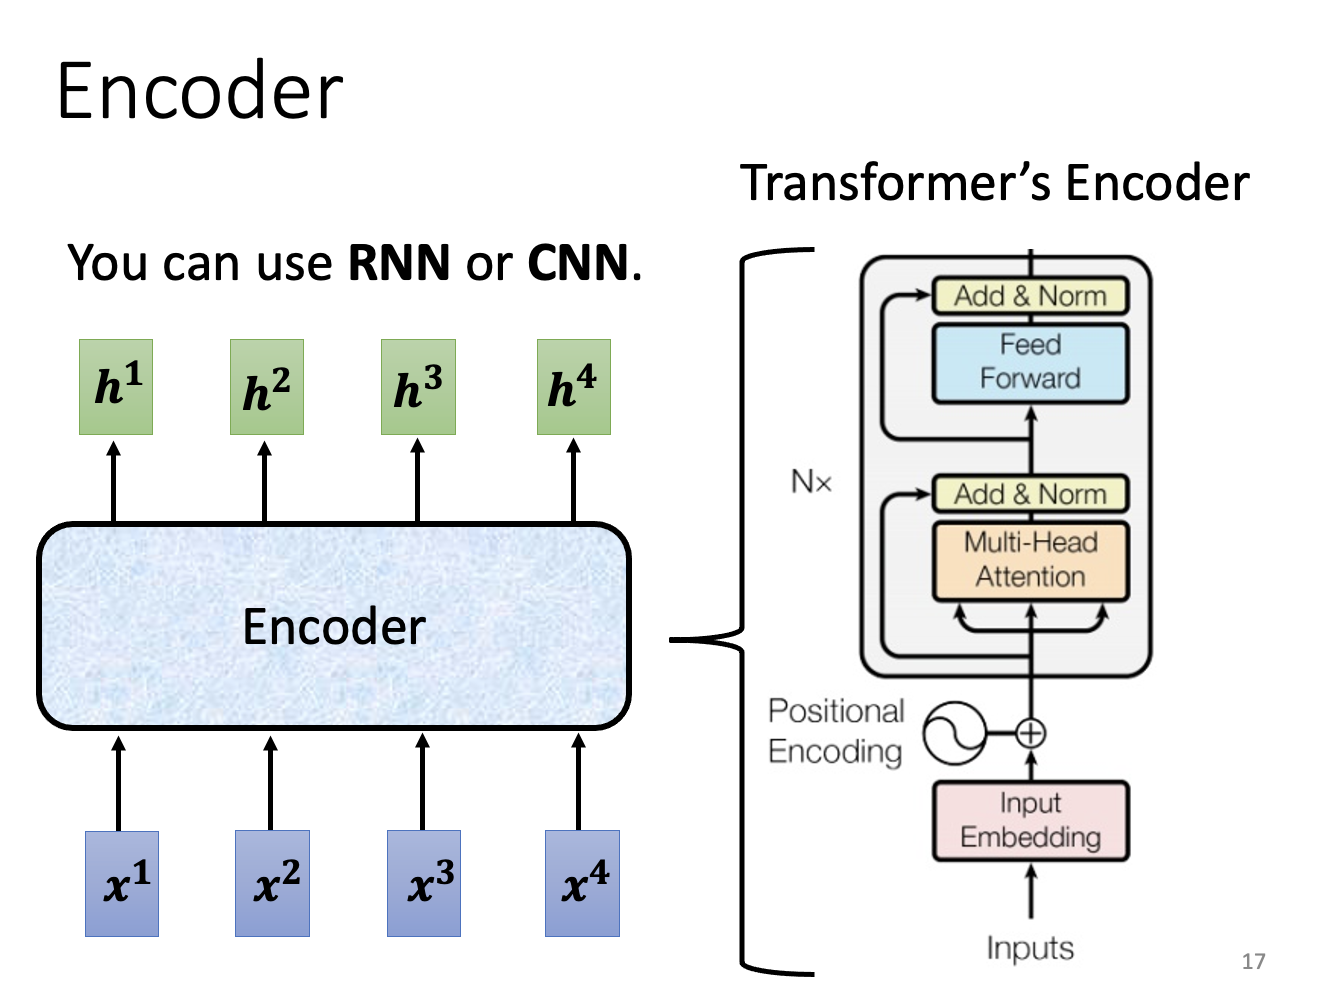

In [6]:
class EncoderBlock(nn.Module):
  """transformer编码器块"""
  def __init__(self, key_size, query_size, value_size, num_hiddens,
               norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
               dropout, use_bias=False, **kwargs):
    super().__init__(**kwargs)
    self.attention = MultiHeadAttention(
        key_size, query_size, value_size, num_hiddens, num_heads,
        dropout, use_bias)
    self.addnorm1= AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))

In [7]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, 
                           [100, 24], 24, 48, 
                           8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

## TransformerEncoder

In [8]:
class TransformerEncoder(nn.Module):
  """transformer编码器"""
  def __init__(self, vocab_size, key_size, query_size, value_size,
               num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
               num_heads, num_layers, dropout, use_bias=False, **kwargs):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_layers): 
      self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
  def forward(self, X, valid_lens, *args):
    # 因为位置编码值在-1和1之间，
    # 因此嵌入值乘以嵌入维度的平方根进行缩放， 
    # 然后再与位置编码相加。
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    self.attention_weights = [None] * len(self.blks)
    for i, blk in enumerate(self.blks):
      X = blk(X, valid_lens)
      self.attention_weights[i
            ] = blk.attention.attention.attention_weights
    return X

In [9]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## Decoder

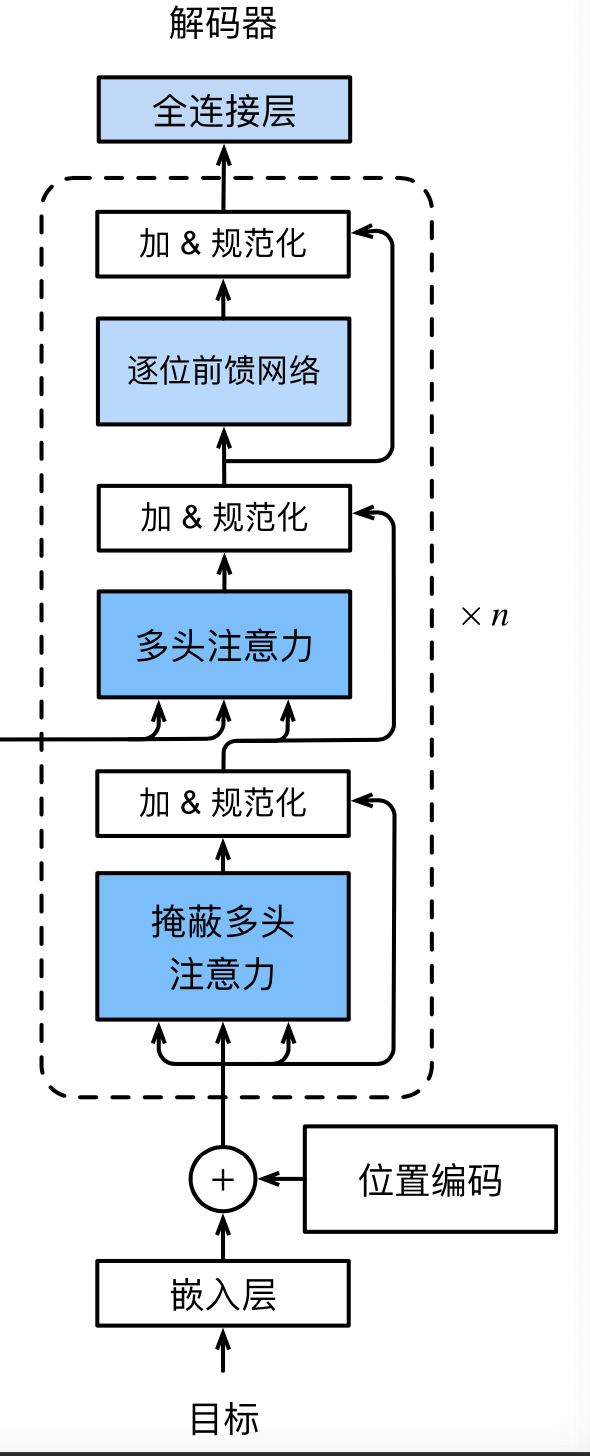

In [10]:
class DecoderBlock(nn.Module):
  """解码器中第i个块"""
  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
    super().__init__(**kwargs)
    self.i = i
    self.attention1 = d2l.MultiHeadAttention(
        key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.attention2 = d2l.MultiHeadAttention(
        key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    self.addnorm2 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                num_hiddens)
    self.addnorm3 = AddNorm(norm_shape, dropout)

  def forward(self, X, state):
    enc_outputs, enc_valid_lens = state[0], state[1]
    # 训练阶段，输出序列的所有词元都在同一时间处理，
    # 因此state[2][self.i]初始化为None。
    # 预测阶段，输出序列是通过词元一个接着一个解码的，
    # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
    if state[2][self.i] is None:
      key_values = X
    else:
      key_values = torch.cat((state[2][self.i], X), axis=1) 
    state[2][self.i] = key_values

    if self.training:
      batch_size, num_steps, _ = X.shape
      # dec_valid_lens的开头:(batch_size,num_steps),
      # 其中每一行是[1,2,...,num_steps] 
      dec_valid_lens = torch.arange(
          1, num_steps + 1, device=X.device).repeat(batch_size, 1) 
    else:
      dec_valid_lens = None

    # 自注意力
    X2 = self.attention1(X, key_values, key_values, dec_valid_lens) 
    Y = self.addnorm1(X, X2)
    # 编码器-解码器注意力。
    # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) 
    Z = self.addnorm2(Y, Y2)
    return self.addnorm3(Z, self.ffn(Z)), state

In [11]:
decoder_blk = DecoderBlock(24, 24, 24, 24, 
                           [100, 24], 24, 48, 8, 
                           0.5, 0) 
decoder_blk.train()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [12]:
class TransformerDecoder(nn.Module):
  def __init__(self, vocab_size, key_size, query_size, value_size,
               num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
               num_heads, num_layers, dropout, **kwargs):
    super().__init__(**kwargs)
    self.num_hiddens = num_hiddens
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                              num_heads, dropout, i))
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):
    return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

  def forward(self, X, state):
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
    for i, blk in enumerate(self.blks):
      X, state = blk(X, state)
      # 解码器自注意力权重 
      self._attention_weights[0][
            i] = blk.attention1.attention.attention_weights # “编码器-解码器”自注意力权重 
      self._attention_weights[1][
            i] = blk.attention2.attention.attention_weights
    return self.dense(X), state

  @property
  def attention_weights(self): 
    return self._attention_weights

## Train

In [13]:
# 1.载入数据集
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [14]:
# 2.定义网络
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

In [15]:
# 3.初始化weight
def xavier_init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m) == nn.GRU:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])

net.apply(xavier_init_weights)

# 4.定义losss和optimizer
loss = MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

epoch: 50, loss:0.282173
epoch: 100, loss:0.182669
epoch: 150, loss:0.151511
epoch: 200, loss:0.135192
epoch: 250, loss:0.131327
epoch: 300, loss:0.122604
epoch: 350, loss:0.119474
epoch: 400, loss:0.115962
epoch: 450, loss:0.114890
epoch: 500, loss:0.107783


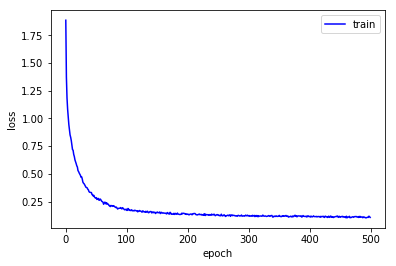

CPU times: user 1min 59s, sys: 1.93 s, total: 2min 1s
Wall time: 2min 2s


In [16]:
%%time
train_seq2seq(net, 500, train_iter, loss, optimizer, tgt_vocab)

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
            net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => pred: {translation} => true: {fra}, bleu {bleu(translation, fra, k=2):.3f}')

go . => pred: va ! => true: va !, bleu 1.000
i lost . => pred: j'ai perdu . => true: j'ai perdu ., bleu 1.000
he's calm . => pred: il est calme . => true: il est calme ., bleu 1.000
i'm home . => pred: je suis chez moi . => true: je suis chez moi ., bleu 1.000
